# Applying TransLOB model to predict the results of horizon 30 on aggreggated Data from 5 stocks of Athex.

In [ ]:
# Importing the libraries.

import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers
from keras.layers import Conv1D, Layer, Concatenate, Dense, Activation, Add, Flatten, Dropout
from keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Data Preparation

In [ ]:
# Load the data and prepare the training, validation and test sets.
dec_data = np.loadtxt('train_case1.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]
dec_test = np.loadtxt('test_case1.txt')

In [ ]:
# Functions to prepare the data for the model.

def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = to_categorical(y, 3)
    return x, y

k = 2  # Which horizon to use for prediction
T = 100  # The input dimension (time steps)
checkpoint_filepath = './model_translob_k2/weights' # Where to save the model weights.

# Prepare the data
X_train, y_train = prepare_x_y(dec_train, k, T)
X_val, y_val = prepare_x_y(dec_val, k, T)
X_test, y_test = prepare_x_y(dec_test, k, T)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (130731, 100, 40)
y_train shape: (130731, 3)
X_val shape: (32609, 100, 40)
y_val shape: (32609, 3)
X_test shape: (82162, 100, 40)
y_test shape: (82162, 3)


# Model Architecture

In [ ]:
def lob_dilated(x):
  """
  TransLOB dilated 1-D convolution module
  """
  x = layers.Conv1D(14,kernel_size=2,strides=1,activation='relu',padding='causal')(x)   
  x = layers.Conv1D(14,kernel_size=2,dilation_rate=2,activation='relu',padding='causal')(x)
  x = layers.Conv1D(14,kernel_size=2,dilation_rate=4,activation='relu',padding='causal')(x)
  x = layers.Conv1D(14,kernel_size=2,dilation_rate=8,activation='relu',padding='causal')(x)
  y = layers.Conv1D(14,kernel_size=2,dilation_rate=16,activation='relu',padding='causal')(x)

  return y

class LayerNormalization(Layer):

    def __init__(self, axis=-1, **kwargs):
        self.axis = axis
        super().__init__(**kwargs)

    def get_config(self):
        config = super().get_config()
        config['axis'] = self.axis
        return config

    def build(self, input_shape):
        dim = input_shape[-1]
        self.gain = self.add_weight(
            name='gain',
            shape=(dim,),
            initializer='ones',
            trainable=True)
        self.bias = self.add_weight(
            name='bias',
            shape=(dim,),
            initializer='zeros',
            trainable=True)
        return super().build(input_shape)

    def call(self, inputs, **kwargs):
        mean = K.mean(inputs, axis=self.axis, keepdims=True)
        variance = K.mean(K.square(inputs - mean), axis=self.axis, keepdims=True)
        epsilon = K.constant(1e-5, dtype=K.floatx())
        normalized_inputs = (inputs - mean) / K.sqrt(variance + epsilon)
        return self.gain * normalized_inputs + self.bias


def positional_encoding(x):
  steps, d_model = x.get_shape().as_list()[-2:] 
  ps = np.zeros([steps,1],dtype=K.floatx()) 
  for tx in range(steps):
    ps[tx,:] = [(2/(steps-1))*tx - 1] 
  ps_expand = K.expand_dims(K.constant(ps),axis=0) 
  ps_tiled = K.tile(ps_expand,[K.shape(x)[0],1,1]) 
  x = K.concatenate([x,ps_tiled],axis=-1)
  return x

def multi_head_self_attention(inputs, num_heads, use_masking, d_model):
    # Validate dimensions
    if d_model % num_heads != 0:
        raise ValueError(f"The size of the last dimension of the input ({d_model}) must be evenly divisible by the number of attention heads ({num_heads}).")
    
    d_submodel = d_model // num_heads
    seq_len = tf.shape(inputs)[1]
    
    # Create Q, K, V transformations
    qkv_layer = Dense(d_model * 3, use_bias=False)
    qkv = qkv_layer(inputs)  # (batch_size, seq_len, d_model * 3)
    
    # Split and reshape Q, K, V
    q, k, v = tf.split(qkv, 3, axis=-1)
    q = tf.reshape(q, (-1, seq_len, num_heads, d_submodel))
    k = tf.reshape(k, (-1, seq_len, num_heads, d_submodel))
    v = tf.reshape(v, (-1, seq_len, num_heads, d_submodel))
    
    # Transpose for attention dot product: (batch_size, num_heads, seq_len, d_submodel)
    q = tf.transpose(q, [0, 2, 1, 3])
    k = tf.transpose(k, [0, 2, 1, 3])
    v = tf.transpose(v, [0, 2, 1, 3])
    
    # Scaled dot-product attention
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(d_submodel, dtype=tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # Masking
    if use_masking:
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        scaled_attention_logits += (mask * -1e9)

    # Softmax is applied to calculate attention coefficients
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # Weighted sum of V with attention coefficients
    output = tf.matmul(attention_weights, v)
    
    # Reshape and transpose back to original input format
    output = tf.transpose(output, [0, 2, 1, 3])
    output = tf.reshape(output, (-1, seq_len, d_model))
    
    return output

def transformer_transition(inputs, activation='relu', size_multiplier=4):
    # Determine the dimensionality of the input feature space
    d_model = inputs.shape[-1]

    # Expand the dimensionality
    expanded_dim = size_multiplier * d_model
    dense_layer1 = Dense(expanded_dim, activation=activation, use_bias=True,
                         kernel_initializer='glorot_uniform', bias_initializer='zeros')
    step1 = dense_layer1(inputs)

    # Contract back to the original dimensionality
    dense_layer2 = Dense(d_model, use_bias=True, 
                         kernel_initializer='glorot_uniform', bias_initializer='zeros')
    output = dense_layer2(step1)

    return output

def transformer_block(inputs, num_heads, use_masking, size_multiplier=4):
    # Assuming multi_head_self_attention and transformer_transition are already defined
    # Multi-head Self-Attention
    attention_output = multi_head_self_attention(inputs, num_heads=num_heads, use_masking=use_masking, d_model=inputs.shape[-1])

    # Residual Connection and Custom Layer Normalization
    post_attention = Add()([inputs, attention_output])
    norm1_output = LayerNormalization()(post_attention)

    # Transition function
    transition_output = transformer_transition(norm1_output, activation='relu', size_multiplier=size_multiplier)

    # Second Residual Connection and Custom Layer Normalization
    post_transition = Add()([norm1_output, transition_output])
    final_output = LayerNormalization()(post_transition)

    return final_output

In [5]:
inputs = tf.keras.Input(shape=(100, 40))
x = lob_dilated(inputs)
x = LayerNormalization(axis=1)(x)
x = positional_encoding(x)
x = transformer_block(x, num_heads=3, use_masking=True)
x = transformer_block(x, num_heads=3, use_masking=True)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.1)(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),#, beta_1=0.9, beta_2=0.999,epsilon=1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

2024-08-10 09:41:55.442424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 40)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 100, 14)      1134        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 100, 14)      406         ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 100, 14)      406         ['conv1d_1[0][0]']               
                                                                                              

# Model Training

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/100
4086/4086 [==============================] - 114s 27ms/step - loss: 1.5388 - accuracy: 0.3705 - val_loss: 1.1131 - val_accuracy: 0.4189
Epoch 2/100
4086/4086 [==============================] - 114s 28ms/step - loss: 1.0782 - accuracy: 0.4240 - val_loss: 1.0737 - val_accuracy: 0.4238
Epoch 3/100
4086/4086 [==============================] - 117s 29ms/step - loss: 1.0501 - accuracy: 0.4449 - val_loss: 1.0581 - val_accuracy: 0.4459
Epoch 4/100
4086/4086 [==============================] - 118s 29ms/step - loss: 1.0370 - accuracy: 0.4582 - val_loss: 1.0779 - val_accuracy: 0.4191
Epoch 5/100
4086/4086 [==============================] - 118s 29ms/step - loss: 1.0283 - accuracy: 0.4693 - val_loss: 1.0679 - val_accuracy: 0.4354
Epoch 6/100
4086/4086 [==============================] - 124s 30ms/step - loss: 1.0212 - accuracy: 0.4787 - val_loss: 1.0773 - val_accuracy: 0.4302
Epoch 7/100
4086/4086 [==============================] - 130s 32ms/step - loss: 1.0142 - accuracy: 0.4879 - val_

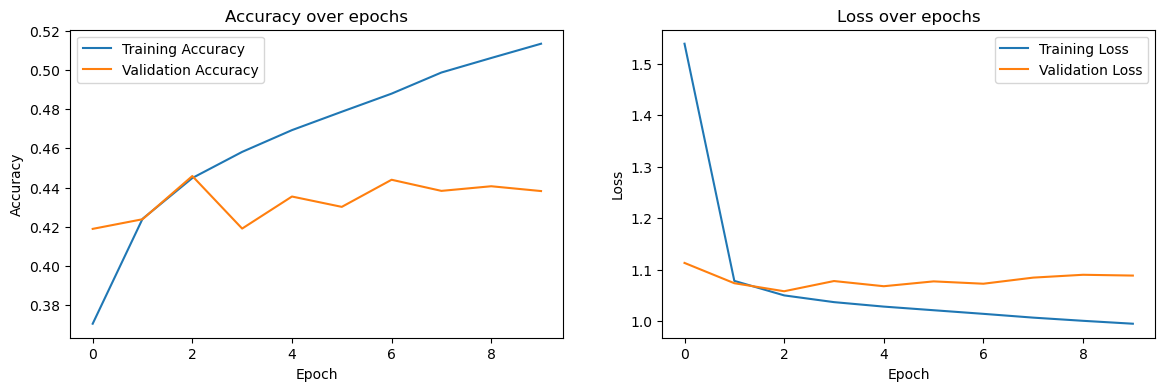

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Model Testing

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions from one-hot encoding to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, digits=4)
print(report)

2568/2568 [==============================] - 29s 11ms/step
              precision    recall  f1-score   support

           0     0.4075    0.3848    0.3958     26764
           1     0.4817    0.6745    0.5620     27637
           2     0.4204    0.2755    0.3329     27761

    accuracy                         0.4453     82162
   macro avg     0.4365    0.4449    0.4302     82162
weighted avg     0.4368    0.4453    0.4304     82162



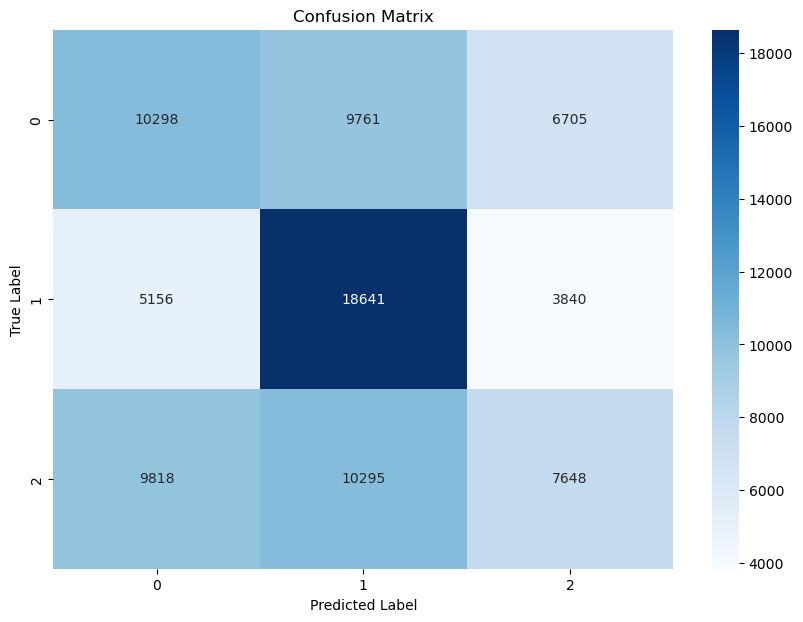

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


# Plotting using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()